In [16]:
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score
from sklearn.tree import plot_tree
import matplotlib.pyplot as plt
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.preprocessing import LabelEncoder, StandardScaler

In [17]:
intrusion_data = pd.read_csv("cybersecurity_intrusion_data.csv")

In [18]:
intrusion_data.head()

,session_id,network_packet_size,protocol_type,login_attempts,session_duration,encryption_used,ip_reputation_score,failed_logins,browser_type,unusual_time_access,attack_detected
0,SID_00001,599,TCP,4,492.983263,DES,0.606818,1,Edge,0,1
1,SID_00002,472,TCP,3,1557.996461,DES,0.301569,0,Firefox,0,0
2,SID_00003,629,TCP,3,75.044262,DES,0.739164,2,Chrome,0,1
3,SID_00004,804,UDP,4,601.248835,DES,0.123267,0,Unknown,0,1
4,SID_00005,453,TCP,5,532.540888,AES,0.054874,1,Firefox,0,0


In [19]:
missed_values = intrusion_data.isnull().sum()
print(missed_values)

session_id                0
network_packet_size       0
protocol_type             0
login_attempts            0
session_duration          0
encryption_used        1966
ip_reputation_score       0
failed_logins             0
browser_type              0
unusual_time_access       0
attack_detected           0
dtype: int64


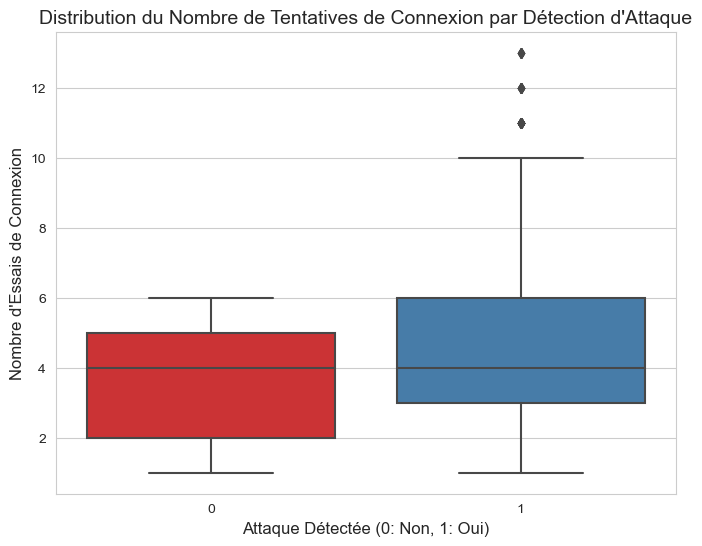

In [20]:
sns.set_style("whitegrid")
plt.figure(figsize=(8, 6))

sns.boxplot(
    x='attack_detected', 
    y='login_attempts', 
    data=intrusion_data, 
    palette='Set1'
)
# Customize labels and title
plt.title("Distribution du Nombre de Tentatives de Connexion par Détection d'Attaque", fontsize=14)
plt.xlabel("Attaque Détectée (0: Non, 1: Oui)", fontsize=12)
plt.ylabel("Nombre d'Essais de Connexion", fontsize=12)
plt.show()

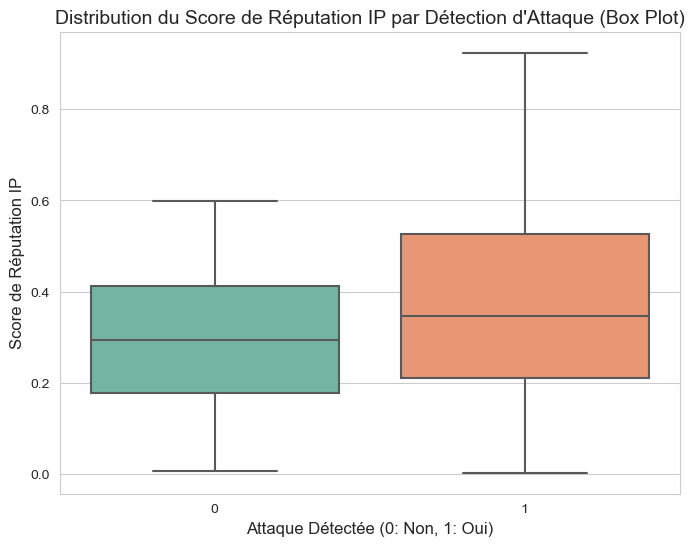

In [21]:
# Set up the plot style
sns.set_style("whitegrid")
plt.figure(figsize=(8, 6))

# Créer le Diagramme en Boîte à Moustaches (Box Plot)
# C'est une alternative courante au Violin Plot pour comparer les distributions
sns.boxplot(
    x='attack_detected', 
    y='ip_reputation_score', 
    data=intrusion_data, 
    palette='Set2'
)

# Customize labels and title
plt.title("Distribution du Score de Réputation IP par Détection d'Attaque (Box Plot)", fontsize=14)
plt.xlabel("Attaque Détectée (0: Non, 1: Oui)", fontsize=12)
plt.ylabel("Score de Réputation IP", fontsize=12)
plt.show()

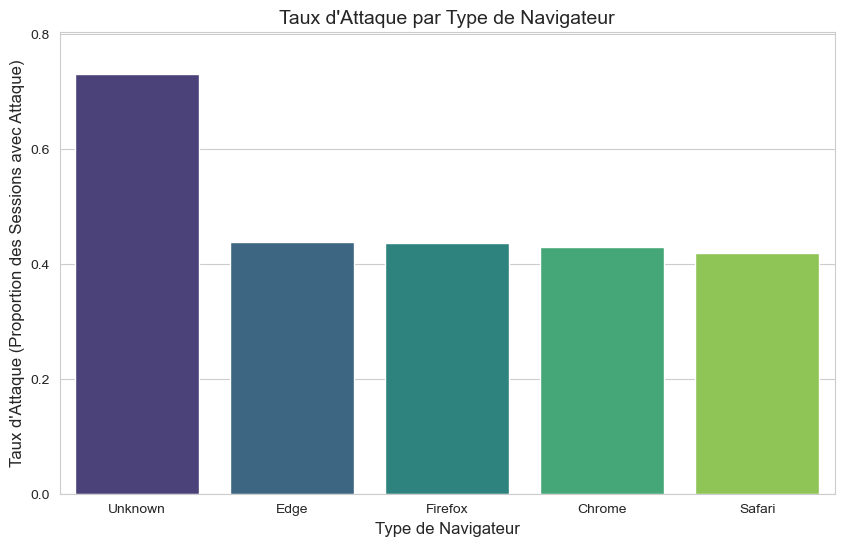

In [22]:
attack_rate_by_browser = intrusion_data.groupby('browser_type')['attack_detected'].mean().reset_index()
attack_rate_by_browser.columns = ['browser_type', 'attack_rate']

# Trier les résultats pour une meilleure visualisation
attack_rate_by_browser = attack_rate_by_browser.sort_values(by='attack_rate', ascending=False)

# 2. Configurer et créer la figure
sns.set_style("whitegrid")
plt.figure(figsize=(10, 6))

# 3. Créer le Diagramme à Barres
sns.barplot(
    x='browser_type', 
    y='attack_rate', 
    data=attack_rate_by_browser, 
    palette='viridis' 
)

# 4. Ajouter les titres et étiquettes
plt.title("Taux d'Attaque par Type de Navigateur", fontsize=14)
plt.xlabel("Type de Navigateur", fontsize=12)
plt.ylabel("Taux d'Attaque (Proportion des Sessions avec Attaque)", fontsize=12)
plt.yticks([0.0, 0.2, 0.4, 0.6, 0.8, 1.0]) # Définir des marques d'axe claires
plt.ylim(0, attack_rate_by_browser['attack_rate'].max() * 1.1) # Ajuster la limite y
plt.show()

c:\Users\julie\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


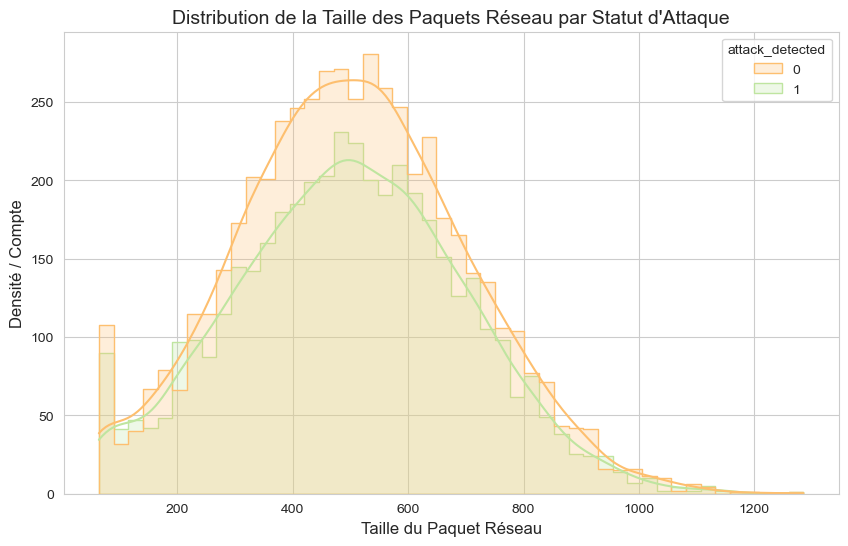

In [23]:
sns.set_style("whitegrid")
plt.figure(figsize=(10, 6))

# Créer l'Histogramme Superposé avec KDE
# 'hue' sépare par classe, 'kde=True' ajoute la courbe de densité
sns.histplot(
    data=intrusion_data, 
    x='network_packet_size', 
    hue='attack_detected', 
    kde=True, 
    palette='Spectral',
    element='step' # Utilise des marches pour les histogrammes superposés
)

# Customize labels and title
plt.title("Distribution de la Taille des Paquets Réseau par Statut d'Attaque", fontsize=14)
plt.xlabel("Taille du Paquet Réseau", fontsize=12)
plt.ylabel("Densité / Compte", fontsize=12)
plt.show()

In [24]:
for col in intrusion_data.columns:
    if intrusion_data[col].dtype == 'object':
        intrusion_data[col].fillna(intrusion_data[col].mode()[0], inplace=True)
    else:
        intrusion_data[col].fillna(intrusion_data[col].mean(), inplace=True)

In [25]:
label_encoders = {}
for col in intrusion_data.select_dtypes(include=['object']).columns:
    le = LabelEncoder()
    intrusion_data[col] = le.fit_transform(intrusion_data[col])
    label_encoders[col] = le

intrusion_data.drop_duplicates(inplace=True)

In [26]:
X = intrusion_data.drop(columns=['attack_detected'])
X=X.drop(columns=['session_id'])

y = intrusion_data['attack_detected']

In [27]:
correlation_matrix = intrusion_data.corr()


correlations = correlation_matrix['attack_detected'].drop('attack_detected')

#Trier par valeur absolue pour voir les plus fortes corrélations
correlations_sorted = correlations.abs().sort_values(ascending=False)

# Afficher les corrélations triées (en reprenant les valeurs non-absolues pour voir la direction)
print("--- Corrélation de chaque variable avec 'attack_detected'")
print(correlations.reindex(correlations_sorted.index).to_markdown(numalign="left", stralign="left"))

--- Corrélation de chaque variable avec 'attack_detected'
|                     | attack_detected   |
|:--------------------|:------------------|
| failed_logins       | 0.363726          |
| login_attempts      | 0.27732           |
| ip_reputation_score | 0.21154           |
| browser_type        | 0.0841672         |
| session_duration    | 0.0416019         |
| protocol_type       | 0.01389           |
| unusual_time_access | 0.00865152        |
| encryption_used     | 0.0083064         |
| network_packet_size | -0.00679795       |
| session_id          | -0.00247341       |


Les colonnes les plus importantes sont failed_logins, login_attempts, ip_reputation_score, browser_type, session_duration

In [28]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [29]:
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.2, random_state=42, stratify=y
)

In [30]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)

# Entraînement

rf_model.fit(X_train, y_train)
# 4. PRÉDICTION ET ÉVALUATION 

# Prédictions sur l'ensemble de test
y_pred_rf = rf_model.predict(X_test)

# Calcul des métriques
accuracy_rf = accuracy_score(y_test, y_pred_rf)
report_rf = classification_report(y_test, y_pred_rf, digits=4)

print("-" * 50)
print(f"Accuracy du modèle Random Forest : {accuracy_rf:.4f}")
print("\nRapport de Classification :\n", report_rf)
print("-" * 50)

--------------------------------------------------
Accuracy du modèle Random Forest : 0.8836

Rapport de Classification :
               precision    recall  f1-score   support

           0     0.8287    0.9953    0.9044      1055
           1     0.9922    0.7456    0.8514       853

    accuracy                         0.8836      1908
   macro avg     0.9105    0.8704    0.8779      1908
weighted avg     0.9018    0.8836    0.8807      1908

--------------------------------------------------


Précision Globale (Accuracy) : 0.8836 (88.36%) - Le modèle est globalement très performant.

Performance Exceptionnelle sur la Classe 1 (Positive) : La Précision (Precision) pour la Classe 1 est de 0.9922, signifiant que lorsque le modèle prédit un '1', il a raison dans presque tous les cas (99.22%). Le modèle est très fiable pour identifier cette classe.

Performance Élevée sur la Classe 0 (Négative) : Le Rappel (Recall) pour la Classe 0 est de 0.9953. Le modèle identifie presque toutes les instances qui appartiennent réellement à la Classe 0.

Point Faible : Rappel de la Classe 1 : Le Rappel (Recall) pour la Classe 1 est de 0.7456. C'est l'indicateur le plus bas. Cela signifie que le modèle manque environ 25.44% des instances réelles de la Classe 1 (il les classe comme Classe 0 - Faux Négatifs).

Bilan : Le modèle minimise fortement les Faux Positifs (grâce à la haute Précision de 0.9922 pour la Classe 1) mais souffre d'un taux modéré de Faux Négatifs (Rappel de 0.7456 pour la Classe 1).

In [31]:
"""from sklearn.model_selection import GridSearchCV

param_grid = {'n_estimators': [100, 300, 500],
    'max_depth': [10, 20, None], # None = pas de limite de profondeur
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2],
    'max_features': ['sqrt']
}

grid_search = GridSearchCV(
    estimator = rf_model,
    param_grid=param_grid,
    scoring='accuracy',
    cv=5,    
    verbose=1,
    n_jobs=-1
)

grid_search.fit(X_train,y_train)"""


"from sklearn.model_selection import GridSearchCV\n\nparam_grid = {'n_estimators': [100, 300, 500],\n    'max_depth': [10, 20, None], # None = pas de limite de profondeur\n    'min_samples_split': [2, 5],\n    'min_samples_leaf': [1, 2],\n    'max_features': ['sqrt']\n}\n\ngrid_search = GridSearchCV(\n    estimator = rf_model,\n    param_grid=param_grid,\n    scoring='accuracy',\n    cv=5,    \n    verbose=1,\n    n_jobs=-1\n)\n\ngrid_search.fit(X_train,y_train)"

In [32]:
"""best_parametre = grid_search.best_params_
print(best_parametre)
print(grid_search.best_score_)"""

'best_parametre = grid_search.best_params_\nprint(best_parametre)\nprint(grid_search.best_score_)'

PARTIE AVEC FEATURE ( Création de dux nouvelles colonnes : taux d'echec de connexion et durée par tentative)


In [33]:
# Taux d'échec de connexion (failure_rate)
intrusion_data['failure_rate'] = np.where(
    intrusion_data['login_attempts'] > 0,
    intrusion_data['failed_logins'] / intrusion_data['login_attempts'],
    0
)

# Durée par tentative (duration_per_attempt)
intrusion_data['duration_per_attempt'] = np.where(
    intrusion_data['login_attempts'] > 0,
    intrusion_data['session_duration'] / intrusion_data['login_attempts'],
    0
)

In [34]:
X = intrusion_data.drop(columns=['attack_detected'])
X=X.drop(columns=['session_id'])

y = intrusion_data['attack_detected']

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.2, random_state=42, stratify=y
)

In [35]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)

# Entraînement

rf_model.fit(X_train, y_train)
# 4. PRÉDICTION ET ÉVALUATION 

# Prédictions sur l'ensemble de test
y_pred_rf = rf_model.predict(X_test)

# Calcul des métriques
accuracy_rf = accuracy_score(y_test, y_pred_rf)
report_rf = classification_report(y_test, y_pred_rf, digits=4)

print("-" * 50)
print(f"Accuracy du modèle Random Forest : {accuracy_rf:.4f}")
print("\nRapport de Classification :\n", report_rf)
print("-" * 50)

--------------------------------------------------
Accuracy du modèle Random Forest : 0.8847

Rapport de Classification :
               precision    recall  f1-score   support

           0     0.8295    0.9962    0.9053      1055
           1     0.9938    0.7468    0.8527       853

    accuracy                         0.8847      1908
   macro avg     0.9116    0.8715    0.8790      1908
weighted avg     0.9029    0.8847    0.8818      1908

--------------------------------------------------


Précision Globale (Accuracy) : 0.8847 (88.47%) - Le modèle reste très performant, avec une amélioration marginale (+0.0011).

Fiabilité de la Classe 1 (Positive) : La Précision pour la Classe 1 est quasi-parfaite à 0.9938. Lorsque le modèle prédit un '1', il a raison dans 99.38% des cas.

Identification de la Classe 0 (Négative) : Le Rappel pour la Classe 0 est extrêmement élevé à 0.9962. Le modèle manque très peu d'instances de la Classe 0.

Point Faible Persistant : Rappel de la Classe 1 : Le Rappel pour la Classe 1 est toujours le point le plus faible à 0.7468. Cela signifie que le modèle manque environ 25.32% des instances réelles de la Classe 1 (Faux Négatifs).

Conclusion : Le modèle excelle à éviter les faux positifs pour la Classe 1, mais sa capacité à trouver toutes les instances de cette classe (le Rappel) pourrait encore être optimisée, selon l'importance des Faux Négatifs pour votre application.

In [36]:
correlation_matrix = intrusion_data.corr()


correlations = correlation_matrix['attack_detected'].drop('attack_detected')

#Trier par valeur absolue pour voir les plus fortes corrélations
correlations_sorted = correlations.abs().sort_values(ascending=False)

# Afficher les corrélations triées (en reprenant les valeurs non-absolues pour voir la direction)
print("--- Corrélation de chaque variable avec 'attack_detected'")
print(correlations.reindex(correlations_sorted.index).to_markdown(numalign="left", stralign="left"))

--- Corrélation de chaque variable avec 'attack_detected'
|                      | attack_detected   |
|:---------------------|:------------------|
| failed_logins        | 0.363726          |
| login_attempts       | 0.27732           |
| ip_reputation_score  | 0.21154           |
| failure_rate         | 0.159811          |
| browser_type         | 0.0841672         |
| session_duration     | 0.0416019         |
| duration_per_attempt | -0.0399736        |
| protocol_type        | 0.01389           |
| unusual_time_access  | 0.00865152        |
| encryption_used      | 0.0083064         |
| network_packet_size  | -0.00679795       |
| session_id           | -0.00247341       |


En comparaison avec les tests sans feature on voit bien que les résultats sont negligeable donc il n'y a pas d'intereret à changer 

AUTRE FEATURE

Implémentation d'une nouvelle colonne qui juge le risque d'une connexion en fonction de son browser_type et de son score d'ip

In [37]:
bins = [0.0, 0.2, 0.5, np.inf]
labels = ['High_Risk', 'Medium_Risk', 'Low_Risk']
intrusion_data['ip_risk_level'] = pd.cut(
    intrusion_data['ip_reputation_score'], 
    bins=bins, 
    labels=labels, 
    right=False, 
    include_lowest=True
)

# --- 2. Création de la Feature d'Interaction (high_risk_combo) ---
condition = (intrusion_data['browser_type'] == 'Unknown') & (intrusion_data['ip_reputation_score'] < 0.2)
intrusion_data['high_risk_combo'] = np.where(condition, 1, 0)

In [38]:
X = intrusion_data.drop(['attack_detected', 'session_id'], axis=1)
y = intrusion_data['attack_detected']

categorical_cols_to_encode = [
    'protocol_type', 
    'encryption_used', 
    'browser_type', 
    'ip_risk_level' 
]

X_encoded = pd.get_dummies(X, columns=categorical_cols_to_encode, drop_first=True)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_encoded)

# --- 3. NOUVELLE SÉPARATION TRAIN/TEST ---

X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, 
    y, 
    test_size=0.2,     
    random_state=42,   
    stratify=y         
)



In [39]:
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)

# Entraînement

rf_model.fit(X_train, y_train)
# 4. PRÉDICTION ET ÉVALUATION 

# Prédictions sur l'ensemble de test
y_pred_rf = rf_model.predict(X_test)

# Calcul des métriques
accuracy_rf = accuracy_score(y_test, y_pred_rf)
report_rf = classification_report(y_test, y_pred_rf, digits=4)

print("-" * 50)
print(f"Accuracy du modèle Random Forest : {accuracy_rf:.4f}")
print("\nRapport de Classification :\n", report_rf)
print("-" * 50)

--------------------------------------------------
Accuracy du modèle Random Forest : 0.8831

Rapport de Classification :
               precision    recall  f1-score   support

           0     0.8291    0.9934    0.9038      1055
           1     0.9891    0.7468    0.8510       853

    accuracy                         0.8831      1908
   macro avg     0.9091    0.8701    0.8774      1908
weighted avg     0.9007    0.8831    0.8802      1908

--------------------------------------------------


Précision Globale (Accuracy) : 0.8831 - Très légèrement inférieure au premier modèle (baisse de 0.0005). La performance globale reste excellente.

Fiabilité de la Classe 1 (Positive) : La Précision pour la Classe 1 est de 0.9891, ce qui est légèrement plus faible que le premier modèle (qui était à 0.9922). Le modèle fait un peu plus de Faux Positifs qu'avant.

Identification de la Classe 0 (Négative) : Le Rappel pour la Classe 0 est de 0.9934, ce qui est légèrement plus faible que le premier modèle (qui était à 0.9953). Le modèle manque légèrement plus d'instances de la Classe 0 qu'avant.

Rappel de la Classe 1 (Point Faible) : Le Rappel pour la Classe 1 est de 0.7468, ce qui est très légèrement supérieur au premier modèle (qui était à 0.7456). Le modèle est marginalement meilleur pour identifier les instances réelles de la Classe 1.

Bilan : Ce modèle est très similaire au premier, mais il a une précision légèrement plus faible dans la classification de la Classe 1 et la Classe 0 (Rappel), en échange d'un rappel de la Classe 1 très légèrement meilleur. Les différences sont minimes et les deux modèles offrent une performance très comparable.

On remarque une légère amélioration dans toutes les métriques néanmoins il n'y a rien de vraiment significatif

In [40]:
label_encoders = {}
for col in intrusion_data.select_dtypes(include=['object']).columns:
    le = LabelEncoder()
    intrusion_data[col] = le.fit_transform(intrusion_data[col])
    label_encoders[col] = le

intrusion_data.drop_duplicates(inplace=True)

In [41]:
data_corr_encoded = pd.concat([X_encoded, y], axis=1)

# 2. Calculer la matrice de corrélation
correlation_matrix = data_corr_encoded.corr()

# 3. Extraire la corrélation de toutes les features avec 'attack_detected'
correlations = correlation_matrix['attack_detected'].drop('attack_detected')

# 4. Trier par valeur absolue pour voir les plus fortes corrélations
correlations_sorted = correlations.abs().sort_values(ascending=False)

# Afficher les corrélations triées (avec les nouvelles features)
print("--- Corrélation de chaque variable avec 'attack_detected' (avec les nouvelles features) ---")
print(correlations.reindex(correlations_sorted.index).to_markdown(numalign="left", stralign="left"))

--- Corrélation de chaque variable avec 'attack_detected' (avec les nouvelles features) ---
|                           | attack_detected   |
|:--------------------------|:------------------|
| failed_logins             | 0.363726          |
| login_attempts            | 0.27732           |
| ip_risk_level_Low_Risk    | 0.211829          |
| ip_reputation_score       | 0.21154           |
| failure_rate              | 0.159811          |
| browser_type_4            | 0.13463           |
| ip_risk_level_Medium_Risk | -0.0929637        |
| session_duration          | 0.0416019         |
| duration_per_attempt      | -0.0399736        |
| browser_type_3            | -0.0132889        |
| browser_type_2            | -0.0105559        |
| unusual_time_access       | 0.00865152        |
| encryption_used_1         | 0.0083064         |
| browser_type_1            | -0.00805707       |
| protocol_type_2           | 0.00790291        |
| network_packet_size       | -0.00679795       |
| protoc

Les colonnes avec la meilleure correlation failed_logins,login_attempts, ip_risk_level_Low_Risk, ip_reputation_score, failure_rate  

Etape avec des colonnes en moins grace à l'acp

POSSIBILITE D'INSERER L'ACP ICI POUR PLUS DE LOGIQUE

In [42]:
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.metrics import roc_auc_score
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OrdinalEncoder


# HyperParameters Grid
param_grid_rf = {
    'classifier__n_estimators': [100, 200, 300], 
    'classifier__max_depth': [10, 20, None],     
    'classifier__min_samples_leaf': [1, 2, 4],   
    'classifier__max_features': ['sqrt']         
}

cols_to_drop = [
    'attack_detected',      
    'session_id' 
]

X = intrusion_data.drop(cols_to_drop, axis=1)
y = intrusion_data['attack_detected']



# Split Train/Test 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
# Identification of columns type
numerical_features = X.select_dtypes(include=np.number).columns
categorical_features = X.select_dtypes(include='object').columns

#Pipeline construction

# Standard Scaler
numerical_transformer = Pipeline(steps=[
    ('scaler', StandardScaler())
])

# Encoding by  numerotation (Ordinal)
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value='Unknown')), # Gestion des manquants
    ('ordinal', OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1)) # Encodage 0, 1, 2...
])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_features),
        ('cat', categorical_transformer, categorical_features)
    ]
)

#Full dataSet
pipeline_rf_full = Pipeline([
    ('preprocessor', preprocessor), 
    ('classifier', RandomForestClassifier())
])

grid_search_rf_full = GridSearchCV(pipeline_rf_full, param_grid_rf, cv=5, scoring='recall', n_jobs=-1)
grid_search_rf_full.fit(X_train, y_train)

best_model_rf_full = grid_search_rf_full.best_estimator_
y_pred_full = best_model_rf_full.predict(X_test)
y_proba_full = best_model_rf_full.predict_proba(X_test)[:, 1]



Identique à au-dessus mais avec des colonnes en moins 

In [43]:
# Deleting columns
cols_to_drop = [
    'attack_detected',      
    'session_id',           
    'protocol_type',       
    'unusual_time_access',  
    'encryption_used',     
    'network_packet_size'   
]

X = intrusion_data.drop(cols_to_drop, axis=1)
y = intrusion_data['attack_detected']



# Split Train/Test 
X_train_reduced, X_test_reduced, y_train_reduced, y_test_reduced = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
# Identification of columns types
numerical_features = X.select_dtypes(include=np.number).columns
categorical_features = X.select_dtypes(include='object').columns

# Pipeline construction 

# Standard Scaler 
numerical_transformer = Pipeline(steps=[
    ('scaler', StandardScaler())
])

# Numerotation (Ordinal)
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value='Unknown')), # Gestion des manquants
    ('ordinal', OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1)) # Encodage 0, 1, 2...
])

preprocessor_reduced = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_features),
        ('cat', categorical_transformer, categorical_features)
    ],
    
)


#Reduced dataset 
pipeline_rf_reduced = Pipeline([
    ('preprocessor', preprocessor_reduced),
    ('classifier', RandomForestClassifier())
])

grid_search_rf_reduced = GridSearchCV(pipeline_rf_reduced, param_grid_rf, cv=5, scoring='recall', n_jobs=-1)
grid_search_rf_reduced.fit(X_train_reduced, y_train_reduced)

best_model_rf_reduced = grid_search_rf_reduced.best_estimator_
y_pred_reduced = best_model_rf_reduced.predict(X_test_reduced)
y_proba_reduced = best_model_rf_reduced.predict_proba(X_test_reduced)[:, 1]


Best Parameters (Full): {'classifier__max_depth': None, 'classifier__max_features': 'sqrt', 'classifier__min_samples_leaf': 1, 'classifier__n_estimators': 100}
RAPPORT CLASSIFICATION (Random Forest FULL):
              precision    recall  f1-score   support

      Normal       0.83      0.99      0.90      1055
      Attack       0.99      0.75      0.85       853

    accuracy                           0.88      1908
   macro avg       0.91      0.87      0.88      1908
weighted avg       0.90      0.88      0.88      1908

AUC-ROC Score : 0.8801

Best Parameters (Reduced): {'classifier__max_depth': None, 'classifier__max_features': 'sqrt', 'classifier__min_samples_leaf': 1, 'classifier__n_estimators': 100}
RAPPORT CLASSIFICATION (Random Forest REDUCED):
              precision    recall  f1-score   support

      Normal       0.83      0.97      0.90      1055
      Attack       0.96      0.75      0.84       853

    accuracy                           0.88      1908
   macro avg  

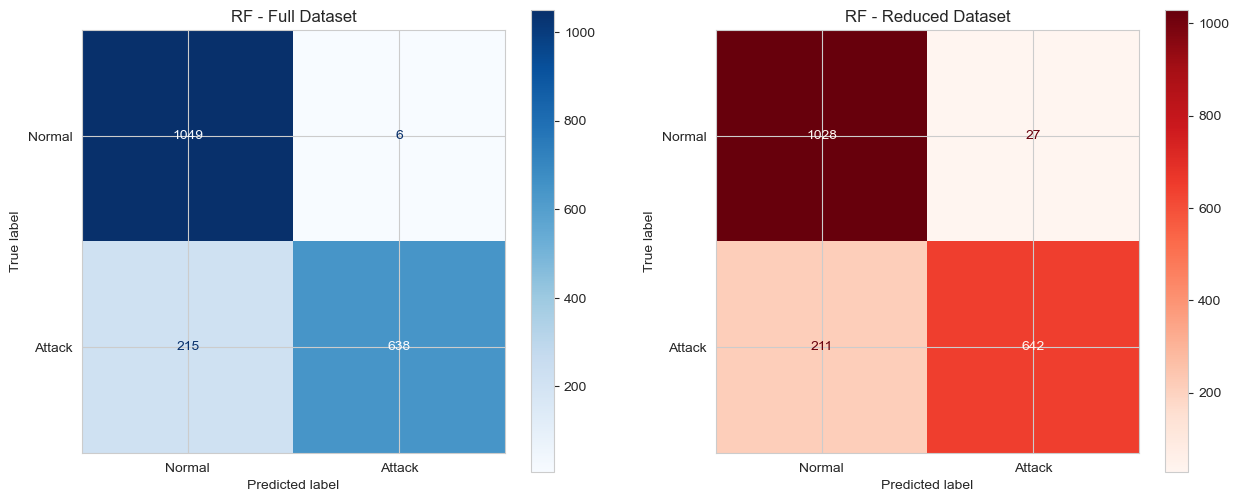

In [44]:
# Results
print(f"\nBest Parameters (Full): {grid_search_rf_full.best_params_}")
print("RAPPORT CLASSIFICATION (Random Forest FULL):")
print(classification_report(y_test, y_pred_full, target_names=['Normal', 'Attack']))
print(f"AUC-ROC Score : {roc_auc_score(y_test, y_proba_full):.4f}")

print(f"\nBest Parameters (Reduced): {grid_search_rf_reduced.best_params_}")
print("RAPPORT CLASSIFICATION (Random Forest REDUCED):")
print(classification_report(y_test_reduced, y_pred_reduced, target_names=['Normal', 'Attack']))
print(f"AUC-ROC Score : {roc_auc_score(y_test_reduced, y_proba_reduced):.4f}")

# Matrices de Confusion
fig, axes = plt.subplots(1, 2, figsize=(15, 6))

ConfusionMatrixDisplay.from_predictions(y_test, y_pred_full, display_labels=['Normal', 'Attack'], cmap='Blues', ax=axes[0])
axes[0].set_title("RF - Full Dataset")

ConfusionMatrixDisplay.from_predictions(y_test_reduced, y_pred_reduced, display_labels=['Normal', 'Attack'], cmap='Reds', ax=axes[1])
axes[1].set_title("RF - Reduced Dataset")

plt.show()

Performance Supérieure du Modèle FULL : Le modèle FULL surpasse le modèle REDUCED sur presque toutes les métriques clés (Accuracy, Précision Attack, Rappel Normal), bien que les différences soient faibles.

Point Faible Identique : Les deux modèles partagent le même point faible : un Rappel de 0.75 pour la classe Attack. Ils manquent tous deux environ 25% des attaques réelles (faux négatifs).

Fiabilité (Précision Attack) : Le modèle FULL est plus fiable lorsqu'il prédit une Attack (99% de précision contre 95%).

Justification du Modèle FULL : Étant donné que le modèle FULL offre des performances supérieures sans différence dans la complexité des hyperparamètres, il serait le choix recommandé si l'ensemble de fonctionnalités complet ne complique pas excessivement le déploiement.


Les données contredisent l'acp car random forest n'est pas sensible au bruit car il ignore de base les colonnes non importantes.


Best Parameters (XGBoost Full): {'classifier__colsample_bytree': 1.0, 'classifier__learning_rate': 0.1, 'classifier__max_depth': 10, 'classifier__n_estimators': 300, 'classifier__subsample': 1.0}
RAPPORT CLASSIFICATION (XGBoost FULL):
              precision    recall  f1-score   support

      Normal       0.83      0.98      0.90      1055
      Attack       0.97      0.75      0.85       853

    accuracy                           0.88      1908
   macro avg       0.90      0.87      0.87      1908
weighted avg       0.89      0.88      0.88      1908

AUC-ROC Score : 0.8752

Best Parameters (XGBoost Reduced): {'classifier__colsample_bytree': 0.8, 'classifier__learning_rate': 0.1, 'classifier__max_depth': 10, 'classifier__n_estimators': 300, 'classifier__subsample': 0.8}
RAPPORT CLASSIFICATION (XGBoost REDUCED):
              precision    recall  f1-score   support

      Normal       0.83      0.95      0.89      1055
      Attack       0.92      0.76      0.83       853

    accu

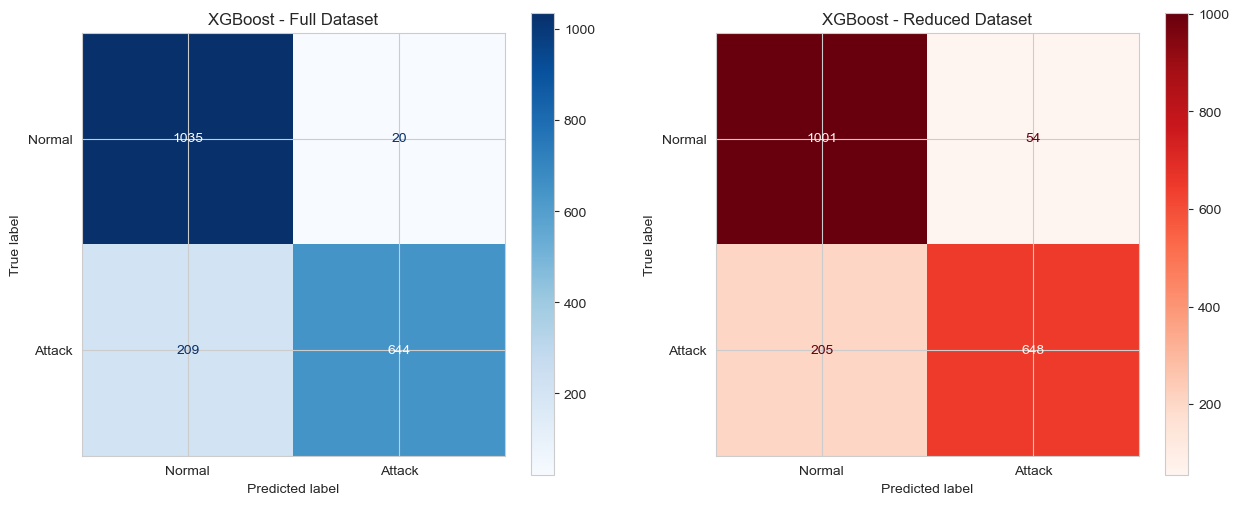

In [46]:
import xgboost as xgb
from sklearn.metrics import accuracy_score, classification_report, roc_auc_score

# Hyperparameters Grid for XGBoost
param_grid_xgb = {
    'classifier__n_estimators': [100, 200, 300],
    'classifier__max_depth': [5, 7, 10],
    'classifier__learning_rate': [0.01, 0.1],
    'classifier__subsample': [0.8, 1.0],
    'classifier__colsample_bytree': [0.8, 1.0]
}

# Full dataset with XGBoost
pipeline_xgb_full = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', xgb.XGBClassifier(random_state=42, use_label_encoder=False, eval_metric='logloss'))
])

grid_search_xgb_full = GridSearchCV(pipeline_xgb_full, param_grid_xgb, cv=5, scoring='recall', n_jobs=-1)
grid_search_xgb_full.fit(X_train, y_train)

best_model_xgb_full = grid_search_xgb_full.best_estimator_
y_pred_xgb_full = best_model_xgb_full.predict(X_test)
y_proba_xgb_full = best_model_xgb_full.predict_proba(X_test)[:, 1]

# Reduced dataset with XGBoost
pipeline_xgb_reduced = Pipeline([
    ('preprocessor', preprocessor_reduced),
    ('classifier', xgb.XGBClassifier(random_state=42, use_label_encoder=False, eval_metric='logloss'))
])

grid_search_xgb_reduced = GridSearchCV(pipeline_xgb_reduced, param_grid_xgb, cv=5, scoring='recall', n_jobs=-1)
grid_search_xgb_reduced.fit(X_train_reduced, y_train_reduced)

best_model_xgb_reduced = grid_search_xgb_reduced.best_estimator_
y_pred_xgb_reduced = best_model_xgb_reduced.predict(X_test_reduced)
y_proba_xgb_reduced = best_model_xgb_reduced.predict_proba(X_test_reduced)[:, 1]

# Results comparison
print(f"\nBest Parameters (XGBoost Full): {grid_search_xgb_full.best_params_}")
print("RAPPORT CLASSIFICATION (XGBoost FULL):")
print(classification_report(y_test, y_pred_xgb_full, target_names=['Normal', 'Attack']))
print(f"AUC-ROC Score : {roc_auc_score(y_test, y_proba_xgb_full):.4f}")

print(f"\nBest Parameters (XGBoost Reduced): {grid_search_xgb_reduced.best_params_}")
print("RAPPORT CLASSIFICATION (XGBoost REDUCED):")
print(classification_report(y_test_reduced, y_pred_xgb_reduced, target_names=['Normal', 'Attack']))
print(f"AUC-ROC Score : {roc_auc_score(y_test_reduced, y_proba_xgb_reduced):.4f}")

# Confusion matrices
fig, axes = plt.subplots(1, 2, figsize=(15, 6))

ConfusionMatrixDisplay.from_predictions(y_test, y_pred_xgb_full, display_labels=['Normal', 'Attack'], cmap='Blues', ax=axes[0])
axes[0].set_title("XGBoost - Full Dataset")

ConfusionMatrixDisplay.from_predictions(y_test_reduced, y_pred_xgb_reduced, display_labels=['Normal', 'Attack'], cmap='Reds', ax=axes[1])
axes[1].set_title("XGBoost - Reduced Dataset")

plt.show()

In [50]:



from sklearn.preprocessing import OneHotEncoder

data = pd.read_csv("cybersecurity_intrusion_data.csv")
cols_to_remove = ["protocol_type", "network_packet_size", "encryption_used", "unusual_time_access", "session_id"]

data_clean = data.drop(columns=cols_to_remove)
categorical_cols = data_clean.select_dtypes(include=['object']).columns

# One-Hot Encoding
onehot_encoder = OneHotEncoder(sparse_output=False, handle_unknown="ignore", drop=None)
encoded_array = onehot_encoder.fit_transform(data_clean[categorical_cols])

encoded_df = pd.DataFrame(
    encoded_array,
    columns=onehot_encoder.get_feature_names_out(categorical_cols),
    index=data_clean.index
)

data_binary_filtered = pd.concat(
    [data_clean.drop(columns=categorical_cols), encoded_df],
    axis=1
)

# =================================================================
# 2. DIVISION DES DONNÉES (SANS SCALING pour Random Forest)
# =================================================================
y = data_binary_filtered["attack_detected"]
X = data_binary_filtered.drop(columns=["attack_detected"])

X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    random_state=42,
    stratify=y  # Maintien de l'équilibre des classes
)

# =================================================================
# 3. ENTRAÎNEMENT DU MODÈLE RANDOM FOREST
# =================================================================
# n_estimators=100 est le défaut. n_jobs=-1 utilise tous les cœurs.
rf_clf = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1) 
rf_clf.fit(X_train, y_train)

# =================================================================
# 4. ÉVALUATION
# =================================================================
y_pred_rf = rf_clf.predict(X_test)
y_proba_rf = rf_clf.predict_proba(X_test)[:, 1] # Pour le score AUC-ROC

print("="*50)
print("PERFORMANCES DU MODÈLE RANDOM FOREST (Données Filtrées)")
print("="*50)

# Accuracy
acc = accuracy_score(y_test, y_pred_rf)
print(f"Accuracy du modèle Random Forest : {acc:.4f}\n")

# Classification Report
print("Rapport de Classification :")
print(classification_report(y_test, y_pred_rf, target_names=['Normal', 'Attack']))

# AUC-ROC Score
auc_roc = roc_auc_score(y_test, y_proba_rf)
print(f"AUC-ROC Score : {auc_roc:.4f}")

PERFORMANCES DU MODÈLE RANDOM FOREST (Données Filtrées)
Accuracy du modèle Random Forest : 0.8684

Rapport de Classification :
              precision    recall  f1-score   support

      Normal       0.82      0.97      0.89      1055
      Attack       0.95      0.74      0.83       853

    accuracy                           0.87      1908
   macro avg       0.89      0.86      0.86      1908
weighted avg       0.88      0.87      0.87      1908

AUC-ROC Score : 0.8784
